# Sentiment Analysis

In [1]:

import sys
from os import chdir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

sys.path.insert(0, '..')

from src.const import TEST_DATA_PATH, TRAIN_DATA_PATH, CACHE_DIR
from src.preprocessing.DataCleaner import DataCleaner
from src.preprocessing.Stemmer import Stemmer
import warnings

In [2]:
MAX_FEATURES = 200_000
RANDOM_SEED = 42
SAMPLE_SIZE = 0.01

In [3]:
# change directory to root
chdir('..')

# Load & Prepare Data

In [4]:
# loading data, we will use only review and label columns, and skip description column with index 1
train_data = pd.read_csv(TRAIN_DATA_PATH, names=['label', 'review'], usecols=[0, 2])
test_data = pd.read_csv(TEST_DATA_PATH, names=['label', 'review'], usecols=[0, 2])
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (3000000, 2)
Test data shape: (650000, 2)


In [5]:
# drop neutral labels
train_data = train_data[train_data['label'] != 3]
test_data = test_data[test_data['label'] != 3]

# change the labels to 0 for negative and 1 for positive
train_data['label'] = train_data['label'].apply(lambda x: 0 if x < 3 else 1)
test_data['label'] = test_data['label'].apply(lambda x: 0 if x < 3 else 1)

# Sample Data

In [6]:
# sample the data to speed up the experiments
# make sure to stratify the data to keep the same distribution of labels
train_data, _ = train_test_split(train_data, test_size=(1 - SAMPLE_SIZE), stratify=train_data['label'],
                                 random_state=RANDOM_SEED)
test_data, _ = train_test_split(test_data, test_size=(1 - SAMPLE_SIZE), stratify=test_data['label'],
                                random_state=RANDOM_SEED)

# Preprocessing Pipeline

The pipeline will consist of the following steps:

1. Data Cleaning:
    - Convert all words to lowercase.
    - Remove stopwords.
    - Remove punctuation.
    - Remove URLs.
    - Remove handles (e.g., Twitter handles).
    - Remove emojis.
    - Remove extra spaces.

2. Stemming:
    - Reduce words to their root form using a stemming algorithm.

3. Vectorization:
    - Convert text into a matrix of token counts.
    - Set the ngram_range parameter to (1, 2) to include both individual words and pairs of consecutive words.
    - Use a predefined constant MAX_FEATURES to limit the number of most frequent words, discarding less frequent words.

4. TF-IDF Transformation:
    - Transform the matrix of token counts into a normalized TF-IDF representation.
    - This step reduces the importance of frequently occurring words and increases the importance of rarely occurring words, which could be more informative.

In [7]:
# In jupyter notebook, we will use only part of the data for more efficient data analysis and models comparison.
# Split the data into train and test sets
X_train = train_data['review']
y_train = train_data['label']
X_test = test_data['review']
y_test = test_data['label']

In [8]:
# create a pipeline
preprocessing_pipeline = Pipeline([
    ('cleaner', DataCleaner()),
    ('stemmer', Stemmer()),
    ('vectorizer', CountVectorizer(ngram_range=((1, 2)), max_features=MAX_FEATURES)),
    ('tfidf', TfidfTransformer()),
],
    verbose=True,
    memory=CACHE_DIR
)

In [9]:
# preprocess the data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   9.0s
[Pipeline] ........... (step 2 of 4) Processing stemmer, total=  10.4s
[Pipeline] ........ (step 3 of 4) Processing vectorizer, total=   2.9s
[Pipeline] ............. (step 4 of 4) Processing tfidf, total=   0.0s


# Compare different models

In [10]:
def score_model(model):
    y_pred = model.predict(X_test_preprocessed)
    precision_score = metrics.precision_score(y_test, y_pred)
    recall_score = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    try:
        roc_auc_score = metrics.roc_auc_score(y_test, model.decision_function(X_test_preprocessed))
    except:
        roc_auc_score = metrics.roc_auc_score(y_test, model.predict_proba(X_test_preprocessed)[:, 1])
    return precision_score, recall_score, f1_score, accuracy, roc_auc_score

In [20]:
def plot_confusion_matrix(model, model_name, accuracy, ax):
    y_pred = model.predict(X_test_preprocessed)
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum()
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=ax, cmap='Blues', cbar=False)
    ax.set_title(f"{model_name}\nAccuracy: {accuracy * 100:.2f}%")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

In [12]:
# prepare a dictionary of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'SVM': SVC(max_iter=1000, random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED),
    # 'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_SEED), # takes too long to train
}

In [13]:
# prepare a dictionary of hyperparameters for each classifier
param_distributions = {
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']},
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
    'Random Forest': {'n_estimators': [10, 50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]},
    #'Gradient Boosting': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 10, 20]}
}

In [18]:
results = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'ROC AUC Score'])
models = []

for classifier_name, classifier in classifiers.items():
    random_search = RandomizedSearchCV(classifier, param_distributions=param_distributions[classifier_name], n_iter=10,
                                       cv=5, n_jobs=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        random_search.fit(X_train_preprocessed, y_train)
    models.append(random_search.best_estimator_)
    print(f"Best parameters for {classifier_name}: {random_search.best_params_}")
    precision, recall, f1, accuracy, roc_auc = score_model(random_search.best_estimator_)
    results.loc[len(results)] = [classifier_name, precision, recall, f1, accuracy, roc_auc]

Best parameters for Logistic Regression: {'penalty': 'l2', 'C': 10}
Best parameters for SVM: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 30}


In [22]:
results.head()

,Classifier,Precision,Recall,F1 Score,Accuracy,ROC AUC Score
0,Logistic Regression,0.849825,0.842308,0.846050,0.846731,0.925598
1,SVM,0.696502,0.850000,0.765633,0.739808,0.832670
2,Random Forest,0.786362,0.833846,0.809408,0.803654,0.892733


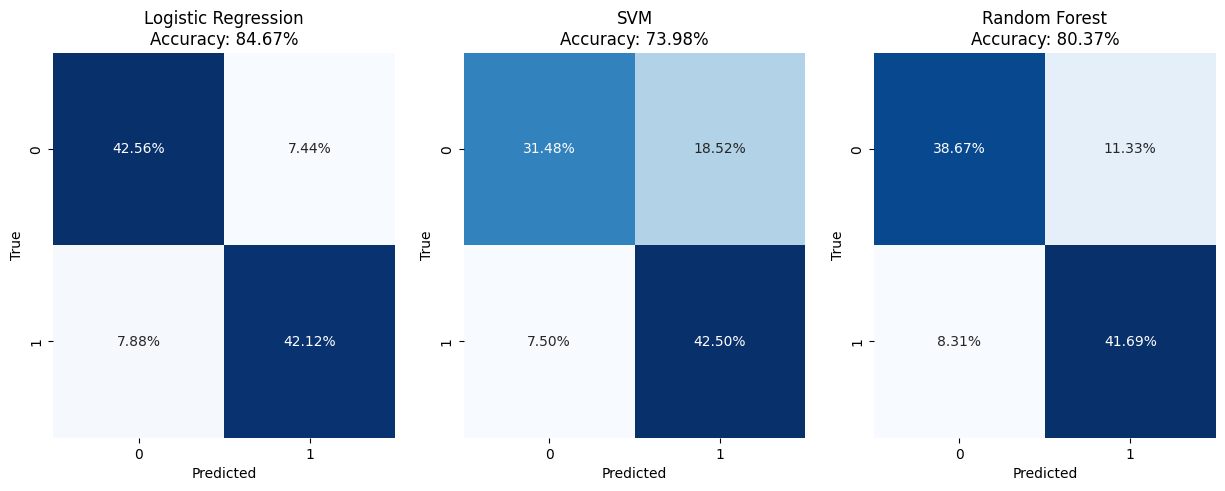

In [21]:
# plot the confusion matrix for each classifier

fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

for i, model in enumerate(models):
    plot_confusion_matrix(model, results['Classifier'][i], results['Accuracy'][i], axes[i])

Based on our experiments, the Logistic Regression model demonstrated the highest accuracy of 84.67%, making it the most effective for our predictions. Therefore, we'll use this model for further analysis and predictions. Now let's better tune the parameters of the Logistic Regression model to improve its performance.

In [23]:
# preparing randomized hyperparameter search for Logistic Regression using 5-fold cross-validation
param_grid = {
    'C': np.logspace(-4, 4, 50),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid = RandomizedSearchCV(LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), param_grid, cv=5, scoring='f1',
                          verbose=1, n_jobs=-1)

In [24]:
grid.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='f1', verbose=1)

In [25]:
print(f"Best parameters: {grid.best_params_}")

Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 7.9060432109076855}


In [26]:
best_model = grid.best_estimator_
precision_score, recall_score, f1_score, accuracy, roc_auc_score = score_model(best_model)
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC score: {roc_auc_score:.4f}")

Precision: 0.8481
Recall: 0.8396
F1 score: 0.8438
Accuracy: 0.8446
ROC AUC score: 0.9257


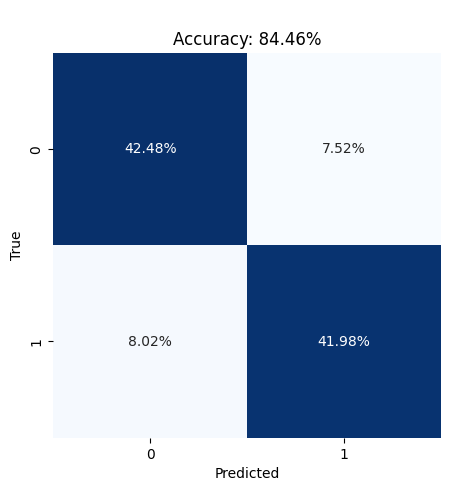

In [27]:
y_pred = best_model.predict(X_test_preprocessed)
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(best_model, '', accuracy, ax=ax)
plt.show()

The parameters for our Logistic Regression model were chosen using a randomized search and will be used in the final model, which will be trained using scripts.